# Introduction

This is the companion workbook to [Picking the Best Model with Caret](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret). Read through the lesson and then come here to complete the exercises so all your work is in one central place.

For this workbook we'll be working with a dataset of FIFA (football/soccer) players from EASports' FIFA video game series. You'll be predicting what a player's rank will be given their other attributes.
____

**Remember**: If you want to share this notebook you need to make it public so that other people can see it. You can do that by forking this notebook and then selecting "public" on the drop-down menu to the left of the "Publish" button.
____
# Table of Contents: 

* [Setting up our environment](#Setting-up-our-environment)
* [Clean our data](#Clean-our-data)
* [Split data into testing & training](#Split-data-into-testing-&-training)
* [Fit a baseline model](#Fit-a-baseline-model)
* [Tune a model using caret](#Tune-a-model-using-caret)
* [Compare our models](#Compare-our-models)

# Setting up our environment
___

Here I've set up the environment for you. Remember to run this cell first or the other cells won't work! :)

In [1]:
install.packages('tidyverse')
install.packages('caret')
install.packages('randomForest')
install.packages('Metrics')
install.packages("dplyr")  
install.packages('xgboost')

package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\aimaz\AppData\Local\Temp\Rtmp88i6bL\downloaded_packages
package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\aimaz\AppData\Local\Temp\Rtmp88i6bL\downloaded_packages
package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\aimaz\AppData\Local\Temp\Rtmp88i6bL\downloaded_packages
package 'Metrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\aimaz\AppData\Local\Temp\Rtmp88i6bL\downloaded_packages
package 'dplyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\aimaz\AppData\Local\Temp\Rtmp88i6bL\downloaded_packages
package 'xgboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\aimaz\AppData\Local\Temp\Rtmp88i6bL\downloaded_packages


In [2]:
# libraries we'll use
library(tidyverse) # utility functions
library(caret) # hyperparameter tuning
library(randomForest)
library(Metrics)#useful metrics
library(xgboost)

# read in data
player_statistics <- read_csv("FullData.csv")

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.1     v purrr   0.3.4
v tibble  3.0.1     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"pac

# Clean our data
___

This datset is pretty clean. All you'll need to do is remove rows with na's and select just the numeric columns.

In [3]:
# omit na's and remove non-numeric columns
player_statistics <- player_statistics %>%
na.omit() %>%
select_if(is.numeric)


Check your dataframe out to make sure it looks reasonable. 

In [4]:
# check out your data frame using the str() function
str(player_statistics)


tibble [1,075 x 41] (S3: tbl_df/tbl/data.frame)
 $ National_Kit      : num [1:1075] 7 10 10 9 1 1 9 11 1 17 ...
 $ Club_Kit          : num [1:1075] 7 10 11 9 1 1 9 11 13 17 ...
 $ Contract_Expiry   : num [1:1075] 2021 2018 2021 2021 2021 ...
 $ Rating            : num [1:1075] 94 93 92 92 92 90 90 90 89 89 ...
 $ Age               : num [1:1075] 32 29 25 30 31 26 28 27 24 28 ...
 $ Weak_foot         : num [1:1075] 4 4 5 4 4 3 4 3 3 4 ...
 $ Skill_Moves       : num [1:1075] 5 4 5 4 1 1 3 4 1 2 ...
 $ Ball_Control      : num [1:1075] 93 95 95 91 48 31 87 88 23 72 ...
 $ Dribbling         : num [1:1075] 92 97 96 86 30 13 85 89 13 67 ...
 $ Marking           : num [1:1075] 22 13 21 30 10 13 25 51 11 90 ...
 $ Sliding_Tackle    : num [1:1075] 23 26 33 38 11 13 19 52 16 91 ...
 $ Standing_Tackle   : num [1:1075] 31 28 24 45 10 21 42 55 18 92 ...
 $ Aggression        : num [1:1075] 63 48 56 78 29 38 80 65 23 82 ...
 $ Reactions         : num [1:1075] 96 95 88 93 85 88 88 87 81 84 ...
 $ Attac

# Split data into testing & training
____

Split your data so that 80% of your data in the training set and 20% is in the testing set. 

In [5]:
# set a random seed
set.seed(1234)

# 80/20 train/test split
# train/test split
training_indexs <- createDataPartition(player_statistics$Rating, p = .2, list = F)
training <- player_statistics[training_indexs, ]
testing  <- player_statistics[-training_indexs, ]


Warning message:
"The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

Convert your predictors into a matrix & get a vector of your target variables.

In [6]:
# get a matrix of predictors and a vector of our target variable
predictors <- training %>% select(-Rating) %>% as.matrix()
output <- training$Rating



# Fit a baseline model
____

Fit a baseline model using randomForest. I'd recommend setting "ntree" to 25.

> **How can I figure out what a good ntree is?** You can check the output of a random tree model as it adds more trees by setting the argument do.trace to TRUE. It will print out the the mean standard error and what percent of the variance your model doesn't explain for each number of trees. You can then pick a ntree that is near the "elbow", the point at which adding additional another three stops dramatically improving your model's fit. 

Once you've trained a model, you can examine it by calling the varaible you assinged it to. (So if you called your model "base_model", you can look at your model by running a line that's just "base_model".)

In [7]:
set.seed(2)
# fit a model
base_model <- randomForest(Rating~.,data=training,
                      ntree = 50) # number of trees

# examine your model
base_model



Call:
 randomForest(formula = Rating ~ ., data = training, ntree = 50) 
               Type of random forest: regression
                     Number of trees: 50
No. of variables tried at each split: 13

          Mean of squared residuals: 5.825615
                    % Var explained: 88.38

Finally, go ahead and calcuate the rmse (root mean squared error) for your base model on your held-out test data.

In [8]:
# find the rmse on our test data
rmse(predict(base_model, testing), testing$Rating)


[1] 2.324056

# Tune a model using caret
____

Now that you have a base model to compare it with, try tuning the model using the "train" function from the caret package. You can examine your model by printing the variable you assigned your model to using the print() function. 

In [9]:

control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")

tunegrid <- expand.grid(.mtry=c(1:9))


set.seed(2)
# tune a model
tuned_model <- train(Rating~.,data=training,
                     ntree=50,
                     method = "rf",
                     tuneGrid=tunegrid, trControl=control)
                     

# examine your tuned model
print(tuned_model)

Random Forest 

216 samples
 40 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 194, 194, 194, 195, 196, 194, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
  1     3.533032  0.8710670  2.639312
  2     2.967221  0.8996644  2.208284
  3     2.681095  0.9151690  1.991042
  4     2.587065  0.9137412  1.919930
  5     2.550440  0.9140494  1.893728
  6     2.486123  0.9124329  1.873312
  7     2.445603  0.9137686  1.813505
  8     2.398602  0.9156664  1.772604
  9     2.427054  0.9117288  1.823713

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 8.


You can also check out the error over the different mtry values that caret tried by passing the model to the ggplot function. 

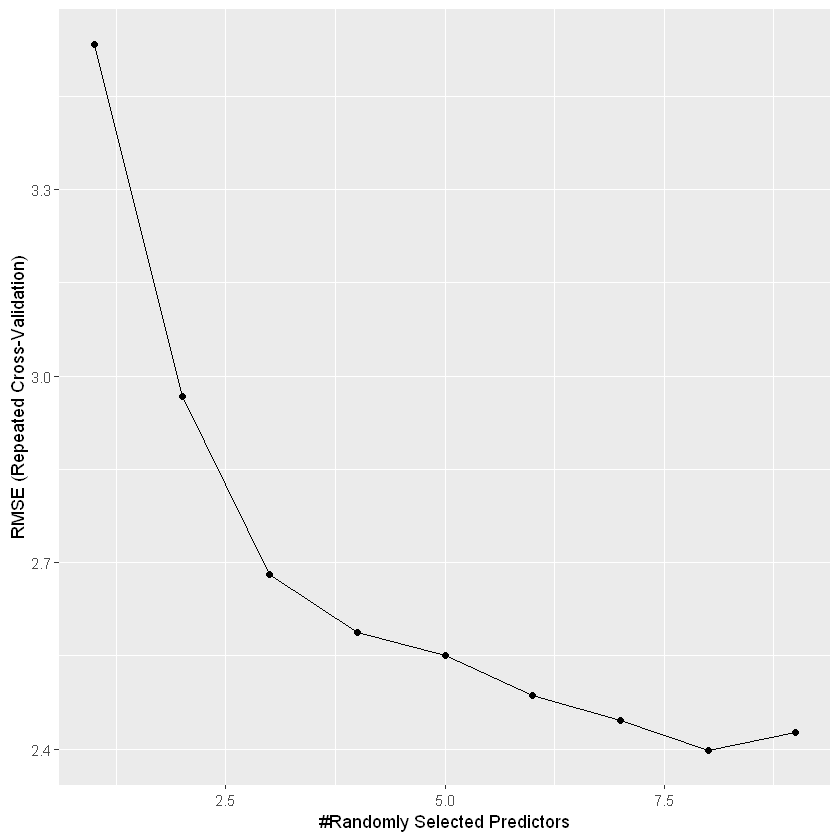

In [10]:
# plot the error over various mtry variables 
ggplot(tuned_model)

# Compare our models
___

Now that we have our two models, let's compare them to each other.

> **Tip:** You can access the automatically-picked best model by getting the finalModel component for your tuned model. So if you called your tuned model ```model_tuned```, the best model would be ```model_tuned$finalModel```.

First, compare the root mean squared error (rmse) for each of your models on the test data. Which model has a lower overall error on the test data? Why might this be?

In [11]:
# get rmse for the base model on the testing data
print("Base model mean error:")
print(rmse(predict(base_model, testing), testing$Rating))

# get rmse for the tuned model on the testing data
print("Tuned model mean error:")
print(rmse(predict(tuned_model$finalModel, testing), testing$Rating))

[1] "Base model mean error:"
[1] 2.324056
[1] "Tuned model mean error:"
[1] 2.315855


Second, look at the five most important varibles for each model. Are the the same?

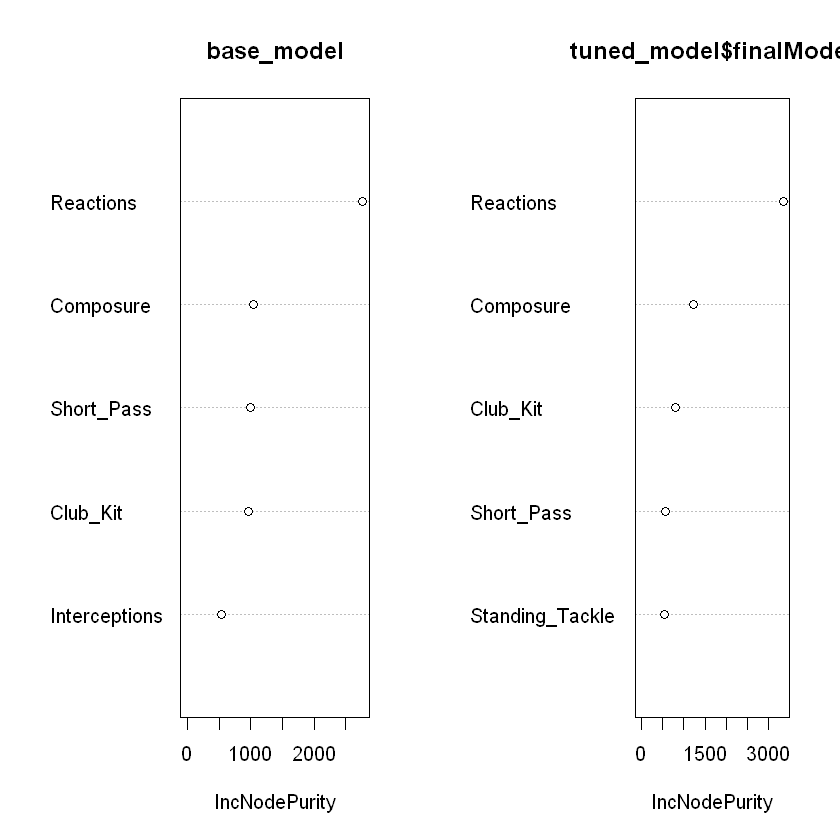

In [12]:
# plot the relative variable importance for our tune & un-tuned models

# two columns, 1 row (for plots)
par(mfrow = c(1,2))

# plot both variable importances
varImpPlot(base_model, n.var = 5)
varImpPlot(tuned_model$finalModel, n.var = 5)


# And that's it! :)
___

Nice work! Now that you've got some practice, why not try using caret to tune a different model, like xgboost? You can check out an [R xgboost tutorial here](https://www.kaggle.com/rtatman/machine-learning-with-xgboost-in-r).

Happy analyzing!

## Caret with Xgboost

### the base xgboost model

In [13]:
nrounds <- 1000

In [14]:
grid_default <- expand.grid(
  nrounds = 100,
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

train_control <- caret::trainControl(
  method = "none",
  verboseIter = FALSE, # no training log
  allowParallel = TRUE # FALSE for reproducible results 
)

xgb_base <- caret::train(
  x = predictors,
  y = output,
  trControl = train_control,
  tuneGrid = grid_default,
  method = "xgbTree",
  verbose = TRUE
)
xgb_base

[16:33:55] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


eXtreme Gradient Boosting 

216 samples
 40 predictor

No pre-processing
Resampling: None 

### 1 finding max_depth

[16:33:56] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:10] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:15] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:17] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:20] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

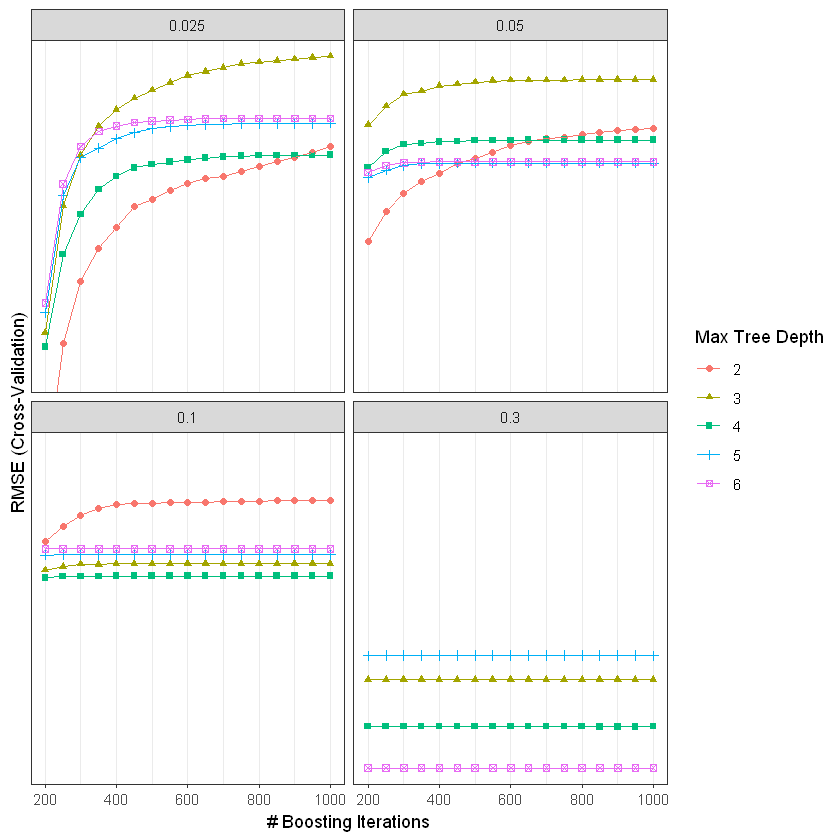

In [15]:
# note to start nrounds from 200, as smaller learning rates result in errors so
# big with lower starting points that they'll mess the scales
tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = c(0.025, 0.05, 0.1, 0.3),
  max_depth = c(2, 3, 4, 5, 6),
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

tune_control <- caret::trainControl(
  method = "cv", # cross-validation
  number = 3, # with n folds 
  #index = createFolds(tr_treated$Id_clean), # fix the folds
  verboseIter = FALSE, # no training log
  allowParallel = TRUE # FALSE for reproducible results 
)

xgb_tune <- caret::train(
  x = predictors,
  y = output,
  trControl = tune_control,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE
)

# helper function for the plots
tuneplot <- function(x, probs = .90) {
  ggplot(x) +
    coord_cartesian(ylim = c(quantile(x$results$RMSE, probs = probs), min(x$results$RMSE))) +
    theme_bw()
}

tuneplot(xgb_tune)

### 2 finding min_child_sample

[16:36:32] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:38] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:46] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:52] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

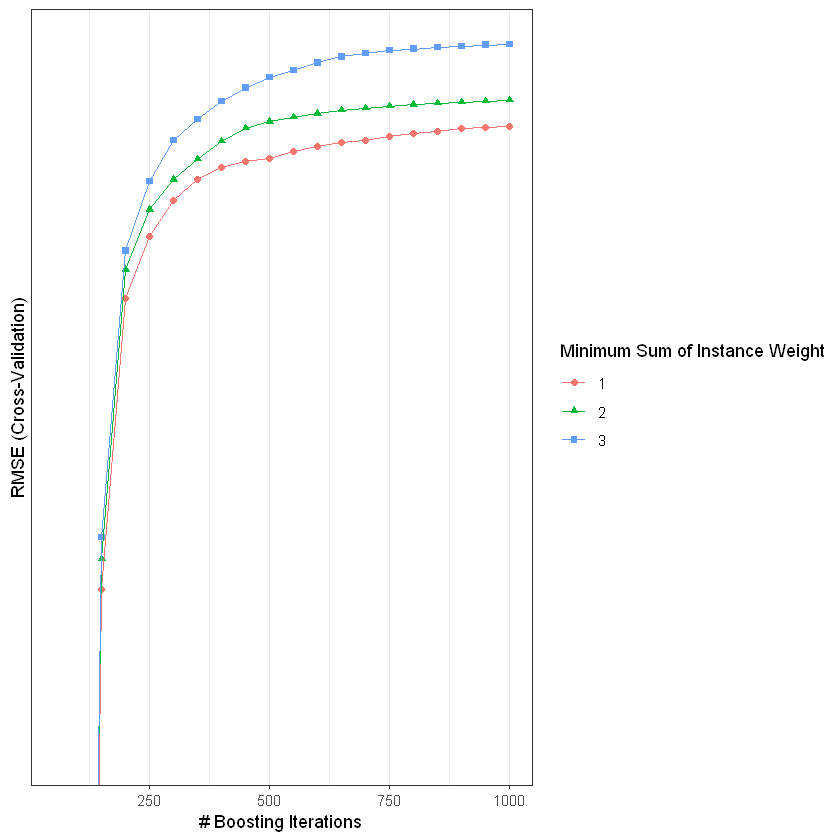

In [16]:
tune_grid2 <- expand.grid(
  nrounds = seq(from = 50, to = nrounds, by = 50),
  eta = xgb_tune$bestTune$eta,
  max_depth = ifelse(xgb_tune$bestTune$max_depth == 2,
    c(xgb_tune$bestTune$max_depth:4),
    xgb_tune$bestTune$max_depth - 1:xgb_tune$bestTune$max_depth + 1),
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = c(1, 2, 3),
  subsample = 1
)

xgb_tune2 <- caret::train(
  x = predictors,
  y = output,
  trControl = tune_control,
  tuneGrid = tune_grid2,
  method = "xgbTree",
  verbose = TRUE
)

tuneplot(xgb_tune2)

### 3 finding colsample_bytree

[16:37:01] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:04] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:06] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:08] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:11] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:13] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

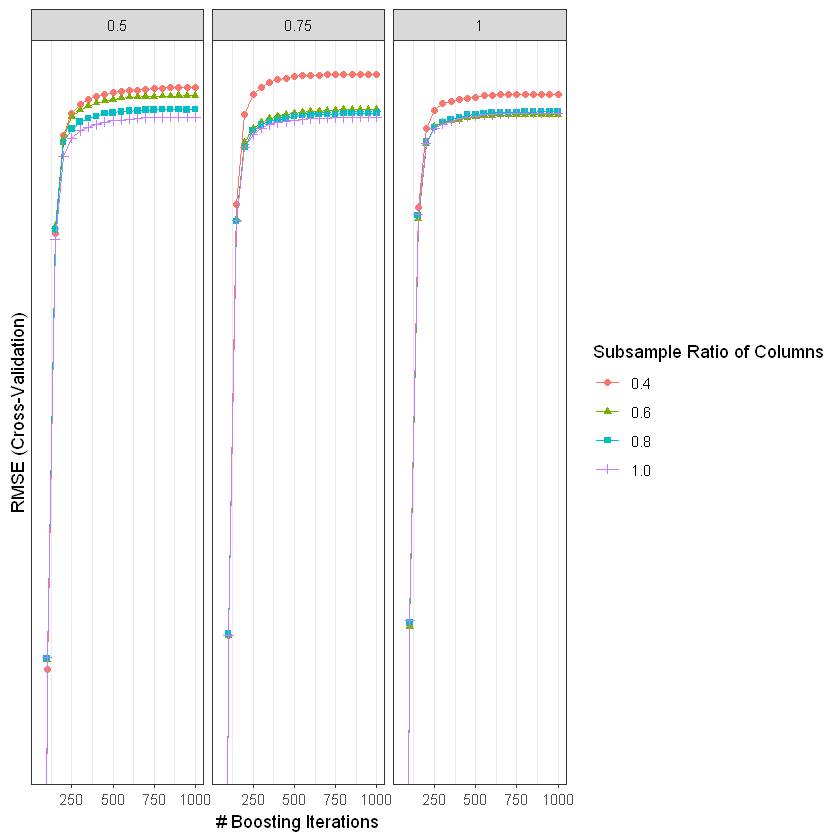

In [17]:
tune_grid3 <- expand.grid(
  nrounds = seq(from = 50, to = nrounds, by = 50),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = 0,
  colsample_bytree = c(0.4, 0.6, 0.8, 1.0),
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = c(0.5, 0.75, 1.0)
)

xgb_tune3 <- caret::train(
  x = predictors,
  y = output,
  trControl = tune_control,
  tuneGrid = tune_grid3,
  method = "xgbTree",
  verbose = TRUE
)

tuneplot(xgb_tune3, probs = .95)

### 4 finding gamma

[16:38:41] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:46] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:51] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:54] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:56] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:58] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

Warning message:
"The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them."Warning message:
"Removed 20 rows containing missing values (geom_point)."

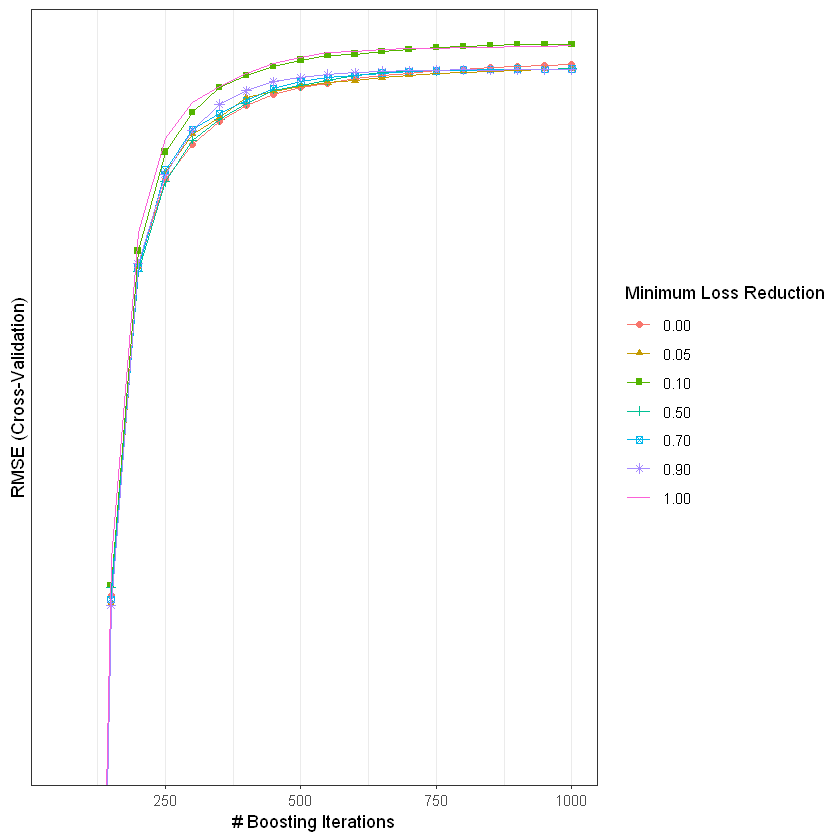

In [18]:
tune_grid4 <- expand.grid(
  nrounds = seq(from = 50, to = nrounds, by = 50),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = c(0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0),
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)

xgb_tune4 <- caret::train(
  x = predictors,
  y = output,
  trControl = tune_control,
  tuneGrid = tune_grid4,
  method = "xgbTree",
  verbose = TRUE
)

tuneplot(xgb_tune4)

### 5 finding eta

[16:39:36] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:45] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

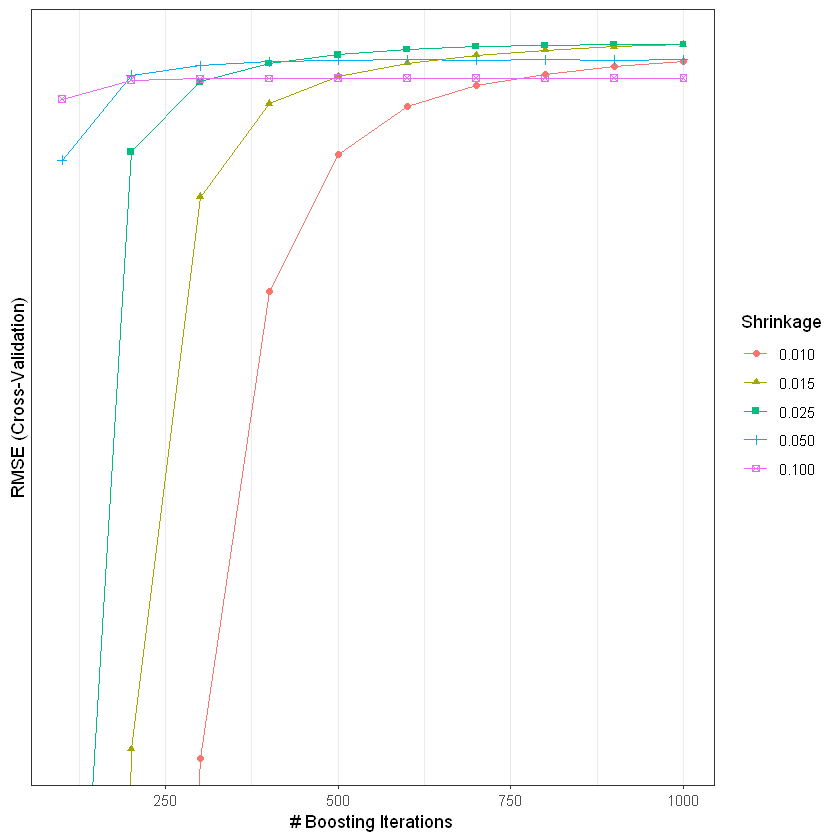

In [19]:
tune_grid5 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 100),
  eta = c(0.01, 0.015, 0.025, 0.05, 0.1),
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = xgb_tune4$bestTune$gamma,
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)

xgb_tune5 <- caret::train(
  x = predictors,
  y = output,
  trControl = tune_control,
  tuneGrid = tune_grid5,
  method = "xgbTree",
  verbose = TRUE
)

tuneplot(xgb_tune5)

In [20]:
(final_grid <- expand.grid(
  nrounds = xgb_tune5$bestTune$nrounds,
  eta = xgb_tune5$bestTune$eta,
  max_depth = xgb_tune5$bestTune$max_depth,
  gamma = xgb_tune5$bestTune$gamma,
  colsample_bytree = xgb_tune5$bestTune$colsample_bytree,
  min_child_weight = xgb_tune5$bestTune$min_child_weight,
  subsample = xgb_tune5$bestTune$subsample
))
(xgb_model <- caret::train(
  x = predictors,
  y = output,
  trControl = train_control,
  tuneGrid = final_grid,
  method = "xgbTree",
  verbose = TRUE
))

nrounds,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample
1000,0.025,3,0.1,0.4,3,0.75


[16:40:15] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


eXtreme Gradient Boosting 

216 samples
 40 predictor

No pre-processing
Resampling: None 

### Comparing RSME of xgb models

In [21]:
# get rmse for the base model on the testing data
print("Base xgb_model mean error:")
print(rmse(predict(xgb_base, testing), testing$Rating))

# get rmse for the tuned model on the testing data
print("Tuned xgb_model mean error:")
print(rmse(predict(xgb_model, testing), testing$Rating))

[1] "Base xgb_model mean error:"
[1] 2.771894
[1] "Tuned xgb_model mean error:"
[1] 2.068039


In [22]:
(1 -(2.016/2.771)) * 100.0

[1] 27.24648

In [24]:
bst <- xgboost(data = as.matrix(predictors), label = output,
               nrounds = xgb_tune5$bestTune$nrounds,
               eta = xgb_tune5$bestTune$eta,
               max_depth = xgb_tune5$bestTune$max_depth,
               gamma = xgb_tune5$bestTune$gamma,
               colsample_bytree = xgb_tune5$bestTune$colsample_bytree,
               min_child_weight = xgb_tune5$bestTune$min_child_weight,
               subsample = xgb_tune5$bestTune$subsample)

[1]	train-rmse:72.352959 
[2]	train-rmse:70.561028 
[3]	train-rmse:68.827667 
[4]	train-rmse:67.128105 
[5]	train-rmse:65.487144 
[6]	train-rmse:63.881775 
[7]	train-rmse:62.322174 
[8]	train-rmse:60.792213 
[9]	train-rmse:59.294861 
[10]	train-rmse:57.832809 
[11]	train-rmse:56.402279 
[12]	train-rmse:55.013279 
[13]	train-rmse:53.672592 
[14]	train-rmse:52.357471 
[15]	train-rmse:51.074398 
[16]	train-rmse:49.835655 
[17]	train-rmse:48.624348 
[18]	train-rmse:47.437370 
[19]	train-rmse:46.278801 
[20]	train-rmse:45.161888 
[21]	train-rmse:44.063320 
[22]	train-rmse:42.989292 
[23]	train-rmse:41.946655 
[24]	train-rmse:40.922073 
[25]	train-rmse:39.928967 
[26]	train-rmse:38.958721 
[27]	train-rmse:38.008278 
[28]	train-rmse:37.080643 
[29]	train-rmse:36.178303 
[30]	train-rmse:35.302452 
[31]	train-rmse:34.448471 
[32]	train-rmse:33.611313 
[33]	train-rmse:32.799377 
[34]	train-rmse:32.005379 
[35]	train-rmse:31.224541 
[36]	train-rmse:30.475798 
[37]	train-rmse:29.742846 
[38]	train

In [28]:
head(xgb.importance(model = bst))

Feature,Gain,Cover,Frequency
Reactions,0.40179789,0.08243852,0.05893609
Composure,0.08018249,0.05067940,0.04171450
Club_Kit,0.07326103,0.02419056,0.02372752
Short_Pass,0.05268767,0.02761248,0.02755454
Standing_Tackle,0.03390763,0.04067738,0.03425182
GK_Positioning,0.02619463,0.03893983,0.03539992


Success, this thorough method cut the error by almost 30%


------------<>------------